1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.stats import norm
import math
from scipy.integrate import trapz

0.9680443728173245
0.965


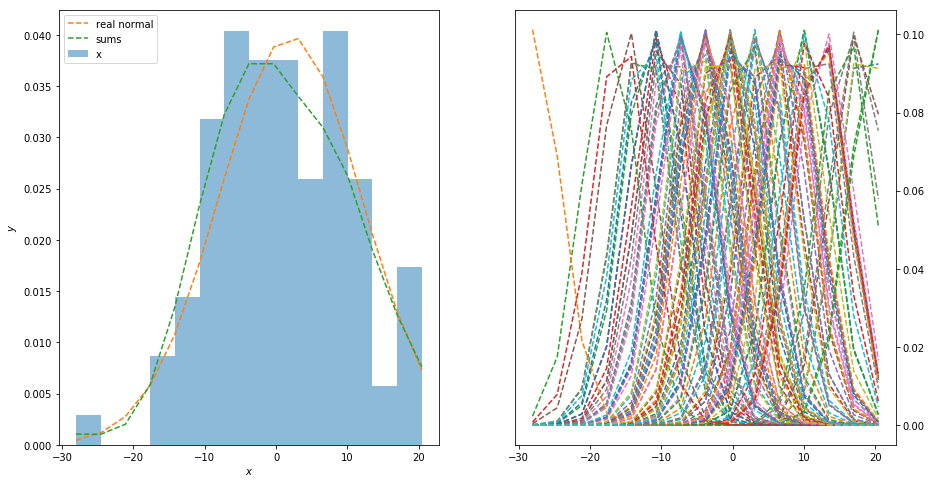

In [121]:
def normal(mu, sigma, n):
    return sigma * np.random.randn(n) + mu
sigma = 10
mu = 2
n_samples = 100
x = normal(mu, sigma,n_samples)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,
                               figsize=(15, 8))
n, bins, patches = ax1.hist(x, bins=n_samples//7,label='x', alpha=0.5, density = True)

y = norm.pdf(bins, mu, sigma)
ax1.plot(bins, y, '--', label = 'real normal')
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')

gaussians = np.array([norm.pdf(bins, i, 1.06*x.std()*math.pow(x.size,-1/5)) for i in x])
for gaussian in gaussians:
    ax2.plot(bins, gaussian, '--')
sums = np.sum(gaussians, axis = 0)/n_samples


ax1.plot(bins, sums, '--', label = 'sums')
ax1.legend(loc='best')
ax2.yaxis.tick_right()
plt.plot()
print(trapz(sums, bins))
print(trapz(n, bins[:-1]))

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

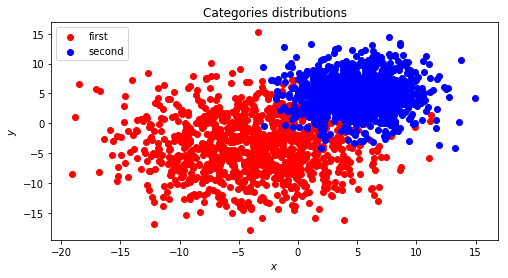

In [11]:
def create_samples(mu, sigma, n):
    samples = np.array([sigma * np.random.randn() + mu, sigma * np.random.randn() + mu])
    for i in range(n-1):
        samples = np.vstack([samples, np.array([sigma * np.random.randn() + mu, sigma * np.random.randn() + mu])])
    return samples
first_cat = create_samples(-4,5,1000)
second_cat = create_samples(5,3,1000)

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

ax1.scatter(first_cat[:,0], first_cat[:,1], marker='o', c='r', label = 'first')
ax1.scatter(second_cat[:,0], second_cat[:,1], marker='o', c='b', label = 'second')
ax1.set_title('Categories distributions')
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')
ax1.legend(loc = 'best')

plt.show()

In [ ]:
! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')


3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should you the `np.load()` function to load the file as a numpy array and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [27]:
import pandas as pd
from scipy import stats
import seaborn as sns

C:\Users\yurin\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


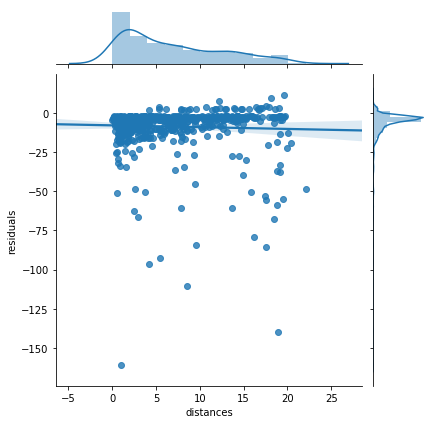

In [63]:
df = pd.DataFrame(np.load('residuals_261.npy').item())
df = df[df.residuals.abs()>2]
slope, intercept, r_value, p_value, std_err = stats.linregress(df.distances,df.residuals)
g = sns.jointplot("distances", "residuals",  data=df, kind="reg")

x_limits = np.linspace(0,20,100)
x = (x_limits[:-1]+x_limits[1:])/2
y = []
erry = []
for i in range(len(x_limits)-1):
    y.append(df.residuals[np.logical_and(df.distances>x_limits[i],df.distances <x_limits[i+1])].mean())
    erry.append(df.residuals[np.logical_and(df.distances>x_limits[i],df.distances <x_limits[i+1])].std())
y = np.array(y)
erry = np.array(erry)
y[np.isnan(y)]=0
erry[np.isnan(erry)]=0

In [61]:
np.isnan(y)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])